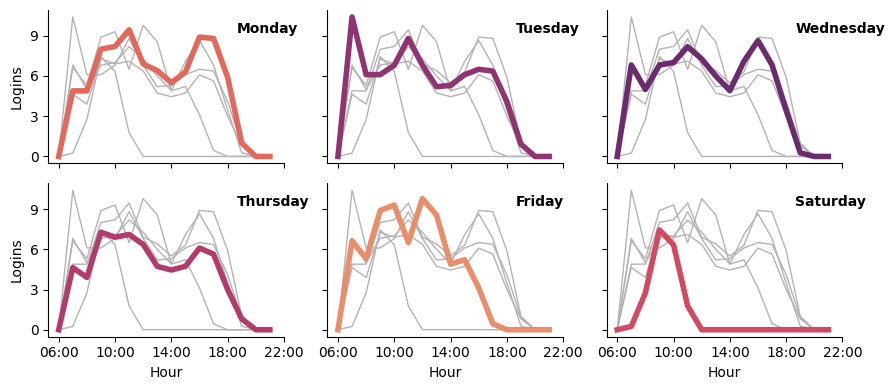

In [15]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

infile = "unifitstats.csv"
hours_start = 7
hours_end = 20

# Read data and filter out datapoints from times where the gym is closed
data_df = pd.read_csv(
    infile, parse_dates=["datetime"], header=0, names=["datetime", "logins", "since"]
)
data_df = data_df[(data_df["since"] >= hours_start) & (data_df["since"] <= hours_end)]


def is_not_in_holidays(dt: datetime) -> bool:
    return not ((dt.day > 22 and dt.month == 12) or (dt.day < 7 and dt.month == 1))


data_df = data_df[data_df["datetime"].apply(is_not_in_holidays)]

# Calculate mean logins by weekday and hour
data_df["weekday"] = data_df["datetime"].apply(lambda d: d.strftime("%A"))
average = data_df.groupby(["weekday", "since"]).mean(numeric_only=True)
average.reset_index(inplace=True)

# Add points at hours_start - 1 and hours_end + 1 for nice presentation in the plot
for wd in average["weekday"].unique():
    average = pd.concat(
        [
            average,
            pd.DataFrame(
                {
                    "weekday": [wd, wd],
                    "since": [hours_start - 1, hours_end + 1],
                    "logins": [0, 0],
                },
                index=[0, 0],
            ),
        ],
        ignore_index=True,
    )

g = sns.relplot(
    data=average,
    col_order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"],
    x="since",
    y="logins",
    col="weekday",
    hue="weekday",
    kind="line",
    palette="flare",
    linewidth=4,
    zorder=5,
    col_wrap=3,
    height=2,
    aspect=1.5,
    legend=False,
)
for weekday, ax in g.axes_dict.items():
    ax.text(0.8, 0.85, weekday, transform=ax.transAxes, fontweight="bold")
    sns.lineplot(
        data=average,
        x="since",
        y="logins",
        units="weekday",
        estimator=None,
        color=".7",
        linewidth=1,
        ax=ax,
    )
xticks = [6, 10, 14, 18, 22]
ax.set_xticks(xticks, labels=list(map(lambda h: f"{h:02}:00", xticks)))
ax.set_yticks([0, 3, 6, 9])
g.set_titles("")
g.set_axis_labels("Hour", "Logins")
g.tight_layout()
plt.savefig("plots/stats_per_day.svg")
